In [66]:
import pathlib
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from skimage.feature import hog

In [67]:
import pathlib
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from skimage.feature import hog

In [68]:
import pathlib
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from skimage.feature import hog

In [69]:
data_dir = pathlib.Path('./output/rgb')
# data_dir = pathlib.Path('./output/rgb_no_circle_det')
image_count = len(list(data_dir.glob('*.jpg')))
print(image_count)

34


In [70]:
def hog_feature_vector(src, pixels_per_cell):
    fd = hog(src, orientations=9, pixels_per_cell=pixels_per_cell, cells_per_block=(1, 1), channel_axis=2)
    # fd = hog(src, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3), channel_axis=2)
    return fd

def image_enhance(src):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    # Top Hat Transform
    topHat = cv2.morphologyEx(src, cv2.MORPH_TOPHAT, kernel)
    # Black Hat Transform
    blackHat = cv2.morphologyEx(src, cv2.MORPH_BLACKHAT, kernel)
    src = src + topHat - blackHat
    # print('enhance on')
    return src

In [71]:
from sklearn.model_selection import train_test_split

rotation_aug = False

experiment_with_gray_scale = True

use_entire_dataset = True

enhance = True

crop = False

load_all_images = False

# pixels_per_cell = (10, 10)
# pixels_per_cell = (20, 20) # MPA
# pixels_per_cell = (50, 50) # MP
pixels_per_cell = (100, 100)
# pixels_per_cell = (125, 125)

# Data selection
molecular_imprinting_name = 'DMMP'
# molecular_imprinting_name = 'MP'
# molecular_imprinting_name = 'MPA'

distraction_merge, distraction_merge_to_one, original_merge_to_one = False, False, False
# distraction_merge, distraction_merge_to_one, original_merge_to_one = False, True, False
# distraction_merge, distraction_merge_to_one, original_merge_to_one = True, False, False
# distraction_merge, distraction_merge_to_one, original_merge_to_one = False, False, True
# distraction_merge, distraction_merge_to_one, original_merge_to_one = False, True, True
# distraction_merge, distraction_merge_to_one, original_merge_to_one = True, False, True

x = []
y = []
for path in data_dir.glob('*.jpg'):
    if not load_all_images:
        if path.name.split('-')[1] != molecular_imprinting_name and path.name.split('-')[1].split('(')[0] != molecular_imprinting_name:
            continue
    src = cv2.imread(str(path))
    if experiment_with_gray_scale:
        src = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
        src = cv2.cvtColor(src, cv2.COLOR_GRAY2RGB)
    else:
        src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    height, width = src.shape[:2]
    center = (width / 2, height / 2)

    if crop:
        height, width = src.shape[:2]
        size = 350
        center = [int(width / 2), int(height / 2)]
        resize_image = src[center[0]-size:center[0]+size, center[1]-size:center[1]+size]

    if rotation_aug:
        for i in range(3):
            rotation_matrix = rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=90 * i, scale=1)
            rotated_image = cv2.warpAffine(src=src, M=rotate_matrix, dsize=(width, height))
            resize_image = cv2.resize(src=src, dsize=(int(width / 2), int(height / 2)))
            if enhance:
                resize_image = image_enhance(resize_image)
            feature_vector = hog_feature_vector(resize_image, pixels_per_cell)
            x.append(feature_vector)
            y.append(path.name.split('-')[2].replace(' ', ''))
    else:
        if enhance:
            src = image_enhance(src)
        feature_vector = hog_feature_vector(src, pixels_per_cell)
        x.append(feature_vector)
        if load_all_images:
            label_name = path.name.split('-')[1].split('(')[0] + '-' + path.name.split('-')[2].replace(' ', '')
            if label_name.split('-')[0] != label_name.split('-')[1]:
                if distraction_merge or distraction_merge_to_one:
                    if distraction_merge_to_one:
                        label_name = 'distraction'
                    else:
                        label_name = label_name.split('-')[0] + '-distraction'
            elif label_name.split('-')[0] == label_name.split('-')[1]:
                if original_merge_to_one :
                    label_name = 'original'
        else:
            if distraction_merge or distraction_merge_to_one:
                if path.name.split('-')[2].split('(')[0] != molecular_imprinting_name:
                    if distraction_merge_to_one:
                        label_name = 'distraction'
                    else:
                        label_name = path.name.split('-')[1].split('(')[0] + '-distraction'
                else:
                    label_name = path.name.split('-')[2].replace(' ', '')
            else:
                label_name = path.name.split('-')[2].replace(' ', '')
        y.append(label_name)

x = np.array(x)
y = np.array(y)
print('data loaded x=%i' % (len(x)))
print('data loaded y=%i' % (len(y)))

data loaded x=10
data loaded y=10


In [72]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, stratify=y)
print(x_train.shape)
print(y_train)
print(y_test)

(7, 900)
['DMMP' 'DMMP' 'KF6P' 'NaBF4' 'KF6P' 'DMMP' 'NaBF4']
['DMMP' 'NaBF4' 'KF6P']


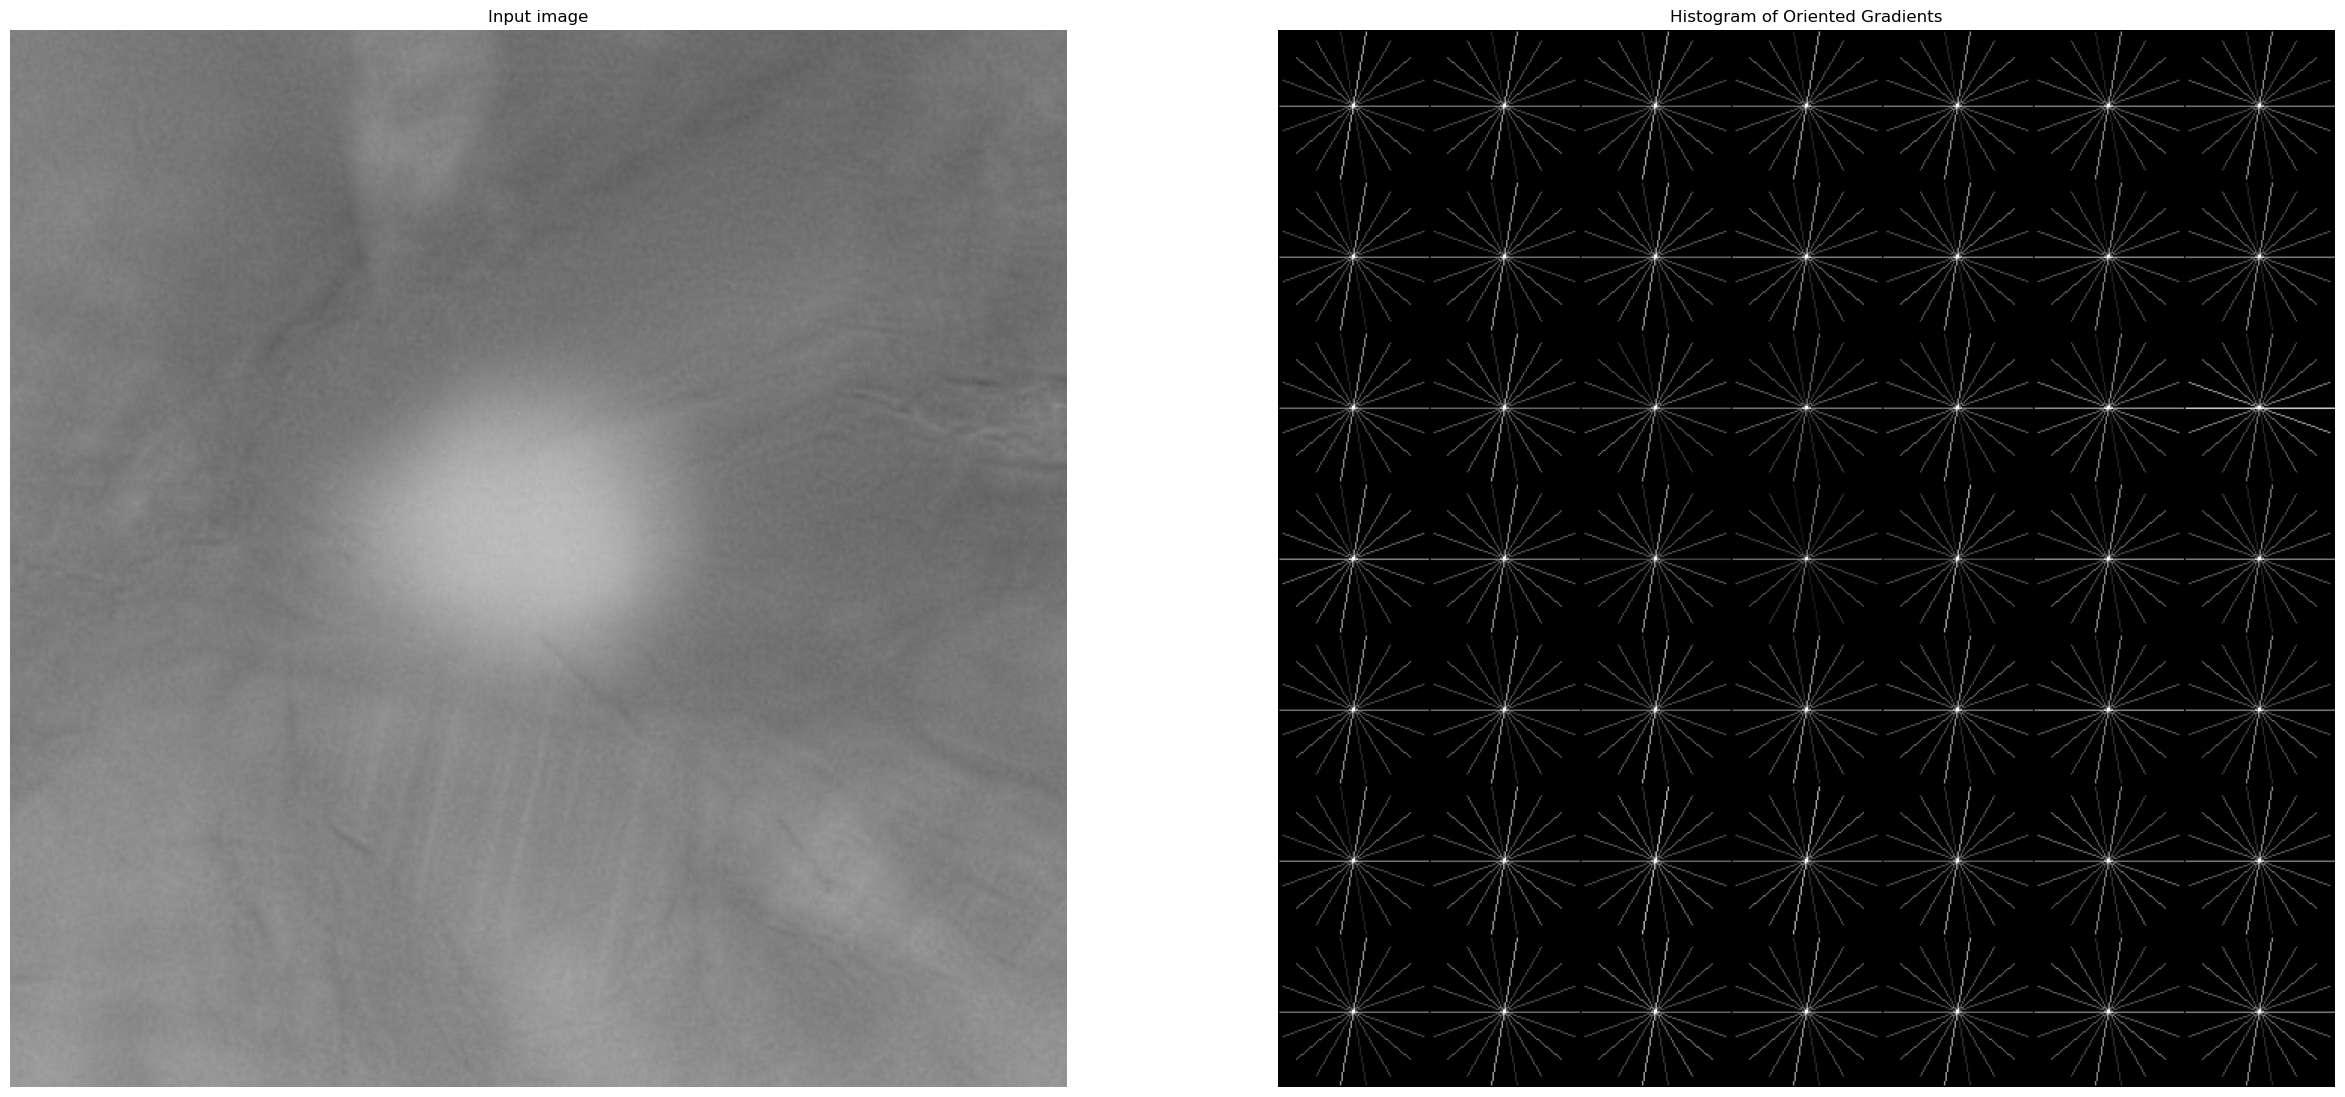

In [73]:
from skimage import exposure

# img = cv2.imread('./output/rgb/M-DMMP- NaBF4-10-6M-1.jpg')
# img = cv2.imread('./output/rgb_no_circle_det/M-DMMP- NaBF4-10-6M-1.jpg')
# img = cv2.imread('output/rgb/M-DMMP(180nm)-MP-10-2M-1.jpg')
img = cv2.imread('output/rgb/M-MPA-KF6P-10-6M-1.jpg')
if experiment_with_gray_scale:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
else:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

if enhance:
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    # Top Hat Transform
    topHat = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, kernel)
    # Black Hat Transform
    blackHat = cv2.morphologyEx(img, cv2.MORPH_BLACKHAT, kernel)
    img = img + topHat - blackHat

height, width = img.shape[:2]
size = 350
center = [int(width / 2), int(height / 2)]
resize_image = img[center[0]-size:center[0]+size, center[1]-size:center[1]+size]

fd, hog_image = hog(resize_image, orientations=9, pixels_per_cell=pixels_per_cell, cells_per_block=(1, 1), visualize=True, channel_axis=2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15))

ax1.axis('off')
ax1.imshow(resize_image)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 1))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [74]:
from skimage import exposure

# img = cv2.imread('output/rgb/M-DMMP(190nm)- NaBF4-10-2M-1.jpg')
img = cv2.imread('./output/rgb/M-DMMP- NaBF4-10-6M-1.jpg')
# img = cv2.imread('output/rgb/M-MP(180nm)-DMMP-10-2M-1.jpg')
fd = hog(img, orientations=9, pixels_per_cell=(30, 30), cells_per_block=(1, 1), channel_axis=2)
print(fd.shape)

(9801,)


DATA MINING

In [75]:
from sklearn.manifold import TSNE

from sklearn.preprocessing import StandardScaler
perplexity=3
pca = TSNE(n_components=3, learning_rate='auto', init='pca', perplexity=perplexity)
if use_entire_dataset:
    x_train_pca = pca.fit_transform(x)
    y_train = y
else:
    x_train_pca = pca.fit_transform(x_train)
    y_train = y_train
x_train_pca

array([[  43.185787 ,   95.940605 ,  -51.312    ],
       [ -76.58849  ,  -80.07551  , -132.15833  ],
       [  31.86469  ,  167.75917  ,    7.070167 ],
       [  81.34962  ,  -30.084675 ,   55.61367  ],
       [ -47.02991  ,   35.019596 ,  -34.085983 ],
       [ -41.730946 ,   41.936893 ,  130.56514  ],
       [  27.159813 ,   -7.054551 ,  115.17562  ],
       [  79.4378   ,  -96.89399  ,  -14.093209 ],
       [   9.721642 ,  -88.283676 ,   -1.4252486],
       [ -57.589787 ,  -38.321465 ,  -55.706554 ]], dtype=float32)

In [76]:
import pandas as pd
n_components=3
df = pd.DataFrame(x_train_pca, columns=[f"PC{i + 1}" for i in range(n_components)])
label_list = []

for i in range(len(x_train_pca)):
    label_list.append(y_train[i])
df['label'] = label_list
df

,PC1,PC2,PC3,label
0,43.185787,95.940605,-51.312000,NaBF4
1,-76.588493,-80.075508,-132.158325,NaBF4
2,31.864691,167.759171,7.070167,NaBF4
3,81.349617,-30.084675,55.613670,DMMP
4,-47.029911,35.019596,-34.085983,DMMP
5,-41.730946,41.936893,130.565140,DMMP
6,27.159813,-7.054551,115.175621,DMMP
7,79.437798,-96.893990,-14.093209,KF6P
8,9.721642,-88.283676,-1.425249,KF6P
9,-57.589787,-38.321465,-55.706554,KF6P


In [77]:
import plotly.io as pio

print(pio.templates)
pio.templates.default = 'plotly'

Templates configuration
-----------------------
    Default template: 'plotly'
    Available templates:
        ['ggplot2', 'seaborn', 'simple_white', 'plotly',
         'plotly_white', 'plotly_dark', 'presentation', 'xgridoff',
         'ygridoff', 'gridon', 'none']



In [78]:
import plotly.express as px

fig = px.scatter_3d(df, x='PC1', y='PC2',z='PC3',  color='label', symbol='label', title='Hog TSNE %s Granularity=%s Sperplexity=%s' % (molecular_imprinting_name, str((int(1000 / pixels_per_cell[0]), int(1000 / pixels_per_cell[0]))), str(perplexity)), color_discrete_map={
                "DMMP": "red",
                "NaBF4": "green",
                "KF6P": "blue",
                "MPA": "goldenrod",
                "MP": "purple"},
                symbol_sequence= ['circle', 'circle', 'circle', 'circle'])
fig.update_layout(scene=dict(
    xaxis=dict(showticklabels=False),
    yaxis=dict(showticklabels=False),
    zaxis=dict(showticklabels=False)
))
fig.show()

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors
from sklearn.svm import SVC

# we only take the first two features. We could avoid this ugly
# slicing by using a two-dim dataset
X = x_train_pca
y = y_train

h = 0.02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(["orange", "cyan"])
cmap_bold = ["darkorange", "c"]

# clf = SVC()
clf = neighbors.KNeighborsClassifier(n_neighbors=1)
clf.fit(X, y)
label_pred = clf.predict(X)

In [80]:
class_dmnp_perd = []
class_mp_perd = []
class_nabf4_perd = []
class_original_pred = []
for i in range(len(X)):
    if y_train[i] == 'DMMP':
        class_dmnp_perd.append(x_train_pca[i])
    elif y_train[i] == 'NaBF4':
        class_nabf4_perd.append(x_train_pca[i])
    elif y_train[i] == 'MP':
        class_mp_perd.append(x_train_pca[i])
    elif y_train[i] == 'Original':
        class_original_pred.append(x_train_pca[i])
    else:
        print('ERROR')

ERROR
ERROR
ERROR


In [81]:
h = 0.1
offset = 1
x_min, x_max = X[:, 0].min() - offset, X[:, 0].max() + offset
y_min, y_max = X[:, 1].min() - offset, X[:, 1].max() + offset
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
# Z = Z.reshape(xx.shape)
Z_new = []
for z in Z:
    if z == 'DMMP':
        Z_new.append(0)
    elif z == 'NaBF4':
        Z_new.append(0.3)
    elif z == 'MP':
        Z_new.append(1)
    elif z == 'Original':
        Z_new.append(0.6)
    else:
        print('ERROR')
Z_new = np.array(Z_new).reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z_new)
plt.scatter(x=[point[0] for point in class_DMMP], y=[point[1] for point in class_DMMP], c='blue', alpha=0.5)
plt.scatter(x=[point[0] for point in class_NaBF4], y=[point[1] for point in class_NaBF4], c='red', alpha=0.5)
plt.scatter(x=[point[0] for point in class_MP], y=[point[1] for point in class_MP], c='green', alpha=0.5)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.legend(['DMNP', 'NaBF4', 'MP'], loc='upper right')
plt.show()

ValueError: X has 2 features, but KNeighborsClassifier is expecting 3 features as input.

In [ ]:
Z

Final Model

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

estimators = [('std', StandardScaler()), ('reduce_dim', PCA(n_components=3)), ('clf', SVC())]
pipe = Pipeline(estimators)
pipe.fit(x_train, y_train)
print(pipe.score(x_test, y_test))
print(classification_report(y_test, pipe.predict(x_test)))

In [ ]:
estimators = [('std', StandardScaler()), ('reduce_dim', PCA(n_components=4)), ('clf', KNeighborsClassifier(1))]
pipe = Pipeline(estimators)
pipe.fit(x_train, y_train)
print(pipe.score(x_test, y_test))
print(classification_report(y_test, pipe.predict(x_test)))

In [ ]:
best = (0, 0)
for i in range(1, 10):
    estimators = [('std', StandardScaler()), ('reduce_dim', PCA(n_components=i)), ('clf', KNeighborsClassifier(1))]
    pipe = Pipeline(estimators)
    pipe.fit(x_train, y_train)
    score = pipe.score(x_test, y_test)
    if score > best[1]:
        best = (i, score)
print(best)

In [ ]:
best = (0, 0)
for i in range(1, 10):
    estimators = [('std', StandardScaler()), ('reduce_dim', PCA(n_components=i)), ('clf', SVC())]
    pipe = Pipeline(estimators)
    pipe.fit(x_train, y_train)
    score = pipe.score(x_test, y_test)
    if score > best[1]:
        best = (i, score)

print(best)

In [ ]:
from matplotlib import cm
# Wrong classification visualization
import matplotlib.image as mpimg

predict_result = pipe.predict(x_test)
wrong_classification = []
wrong_classification_label = []
for i in range(len(predict_result)):
    if predict_result[i] != y_test[i]:
        wrong_classification.append(i)
        wrong_classification_label.append(y_test[i])
print(wrong_classification_label)
for i, path in enumerate(data_dir.glob('*.jpg')):
    if i in wrong_classification:
        img = cv2.imread(str(path))
        label = wrong_classification_label[wrong_classification.index(i)]
        cv2.imshow(label, img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

In [ ]:
# Reverse pattern with PCA
pca = PCA(n_components=3)
pca.fit(x_train)

guess_data = np.array([2, 1.5, -0.25])
data_original = np.dot(guess_data, pca.components_)  # inverse_transform
data_original = np.reshape(data_original, (256, 9))
data_original